In [2]:
%tensorflow_version 1.x
!pip install -q h5py==2.10.0
from scipy.io import loadmat
from scipy import stats
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
#import tensorflow.compat.v1 as tf1
#tf1.disable_v2_behavior()
import seaborn as sns
from pylab import rcParams
from sklearn import metrics
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from numpy import dstack
from pandas import read_csv
from sklearn.svm import SVC
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import ConvLSTM2D

TensorFlow 1.x selected.
     |████████████████████████████████| 2.9 MB 8.2 MB/s 


Using TensorFlow backend.


In [ ]:
# load a single file as a numpy array
def load_file(filepath):
	df = read_csv(filepath)
  # convert activity names to number
	df.activity = pd.factorize(df.activity)[0]
	# select mean and var features
	x1 = df.iloc[:,3:9].values
	x2 = df.iloc[:,21:27].values
	x = np.append(x1,x2,axis=1)
	y = df.activity.values
	print(x.shape, y.shape)
	return x, y
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
	# load all train
	x, y = load_file(prefix + '/sensoringData_feature_prepared_20_19.0_2'+'.csv')
	# transform for LSTM
	N_TIME_STEPS = 20
	step = 10 # faster with bigger step but accuracy degrades fast
	X = []
	Y = []
	num = y.shape[0]
	for i in range(0, num - N_TIME_STEPS, step):
			part = x[i: i + N_TIME_STEPS]
			label = stats.mode(y[i: i + N_TIME_STEPS])[0][0]
			X.append(part)
			Y.append(label)

	trainX, testX, trainy, testy = train_test_split(np.array(X), np.array(Y), test_size=0.2, random_state=42)
	 
	print(trainX.shape, trainy.shape, testX.shape, testy.shape)
	return trainX, trainy, testX, testy
# run an experiment
# load data
trainX, trainy, testX, testy = load_dataset('drive/MyDrive/Thesis/Test Data/HAR Spain')

(499276, 12) (499276,)
(39940, 20, 12) (39940,) (9986, 20, 12) (9986,)


In [ ]:
# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy):
	# define model
	verbose, epochs, batch_size = 1, 15, 64
	n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
	# reshape into subsequences (samples, time steps, rows, cols, channels)
	n_steps, n_length = 2, 10
	trainX = trainX.reshape((trainX.shape[0], n_steps, 1, n_length, n_features))
	testX = testX.reshape((testX.shape[0], n_steps, 1, n_length, n_features))
	# define model
	model = Sequential()
	model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
	model.add(Dropout(0.5))
	model.add(Flatten())
	model.add(Dense(100, activation='relu'))
	model.add(Dense(n_outputs, activation='softmax'))
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	# fit network
	history = model.fit(trainX, trainy, validation_split=0.33, epochs=epochs, batch_size=batch_size, verbose=verbose)
	# evaluate model
	_, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
	return model,history,accuracy


# repeat experiment
# one hot encode y
trainy = to_categorical(trainy)
testy = to_categorical(testy)
model,model_history,score = evaluate_model(trainX, trainy, testX, testy)
score = score * 100.0
print('>#%d: %.3f' % (1, score))



Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 26759 samples, validate on 13181 samples
Epoch 1/10
26759/26759 [==============================] - 12s 448us/step - loss: 0.5807 - accuracy: 0.7977 - val_loss: 0.3905 - val_accuracy: 0.8548
Epoch 2/10
26759/26759 [==============================] - 11s 405us/step - loss: 0.3358 - accuracy: 0.8865 - val_loss: 0.2816 - val_accuracy: 0.9134
Epoch 3/10
26759/26759 [==============================] - 11s 405us/step - loss: 0.2755 - accuracy: 0.9112 - val_loss: 0.2586 - val_accuracy: 0.9227
Epoch 4/10
26759/26759 [==============================] - 11s 424us/step - loss: 0.2440 - accuracy: 0.9204 - val_loss: 0.2377 - val_accuracy: 0.9249
Epoch 5/10
26759/26759 [==============================] - 11s 402us/step - loss: 0.2250 - accuracy: 0.9251 - val_loss: 0.2241 - val_accuracy: 0.9300
Epoch 6/10
26759/26759 [=====

In [ ]:
# reshape data into time steps of sub-sequences
n_features, n_steps, n_length = trainX.shape[2], 2, 10
trainX = trainX.reshape((trainX.shape[0], n_steps, 1, n_length, n_features))
testX = testX.reshape((testX.shape[0], n_steps, 1, n_length, n_features))
X = np.append(trainX, testX, axis=0)
Y = np.append(trainy, testy, axis=0)
Y_cat = np.argmax(Y, axis=1)
ind = np.argsort( Y_cat[:] )
X = X[ind]
Y = Y[ind]
Y_pred = model.predict(np.array(X))
np.shape(Y_pred)

(49926, 4)

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


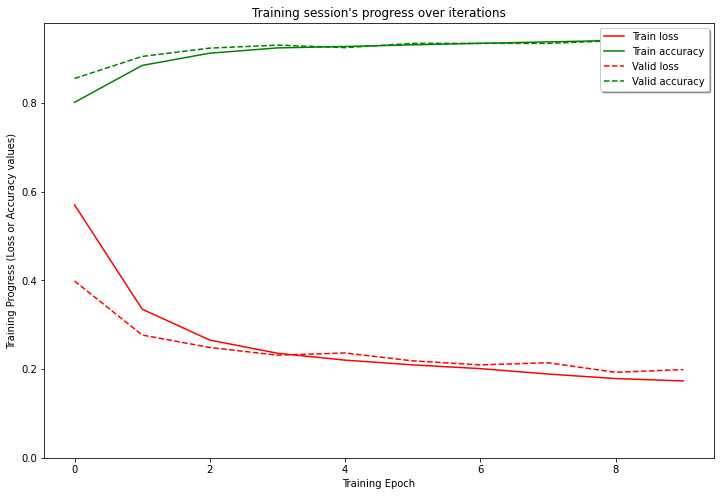

In [ ]:
print(model_history.history.keys())
plt.figure(figsize=(12, 8))
plt.plot(np.array(model_history.history['loss']), "r-", label="Train loss")
plt.plot(np.array(model_history.history['accuracy']), "g-", label="Train accuracy")
plt.plot(np.array(model_history.history['val_loss']), "r--", label="Valid loss")
plt.plot(np.array(model_history.history['val_accuracy']), "g--", label="Valid accuracy")
plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.show()

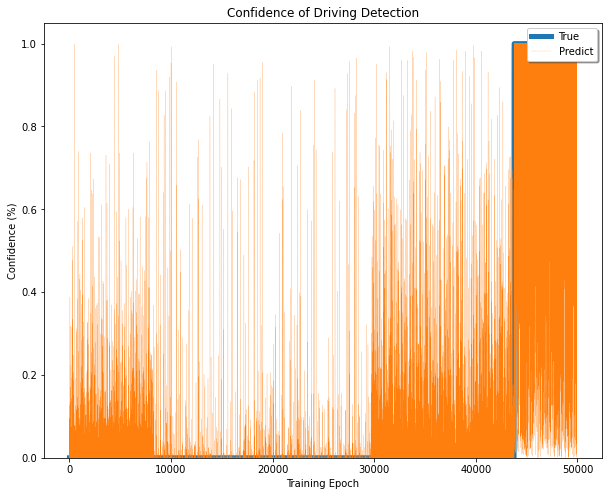

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(np.array(Y[:,3]), linewidth=5.0, label="True")
plt.plot(np.array(Y_pred[:,3]), '--', linewidth=0.20, label="Predict")
plt.title("Confidence of Driving Detection")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Confidence (%)')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.show()

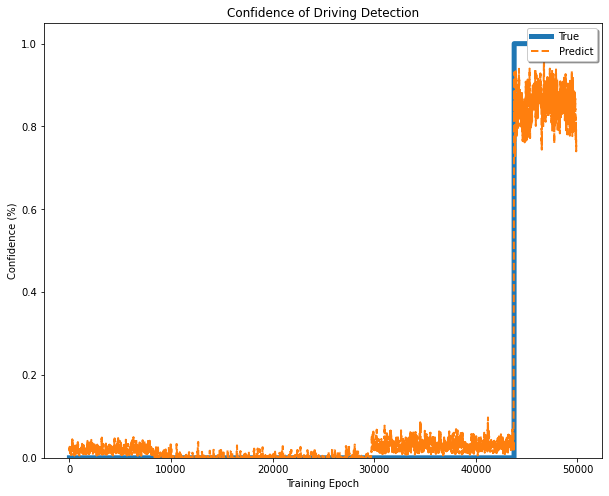

In [ ]:
N = 50
y_f = np.convolve(np.array(Y_pred[:,3]), np.ones(N)/N, mode='valid')

plt.figure(figsize=(10, 8))
plt.plot(np.array(Y[:,3]), linewidth=5.0, label="True")
plt.plot(y_f, '--', linewidth=2.0, label="Predict")
plt.title("Confidence of Driving Detection")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Confidence (%)')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.show()

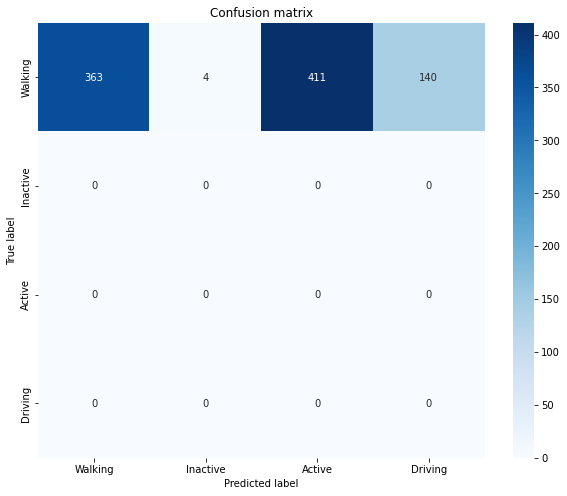

In [ ]:
LABELS = ['Walking','Inactive','Active','Driving']
Y_cat = np.argmax(Y, axis=1)
Y_pred_cat = np.argmax(Y_pred, axis=1)
confusion_matrix = metrics.confusion_matrix(Y_cat, Y_pred_cat)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d",cmap="Blues");
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show();

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(Y_cat, Y_pred_cat)

0.9438769378680447

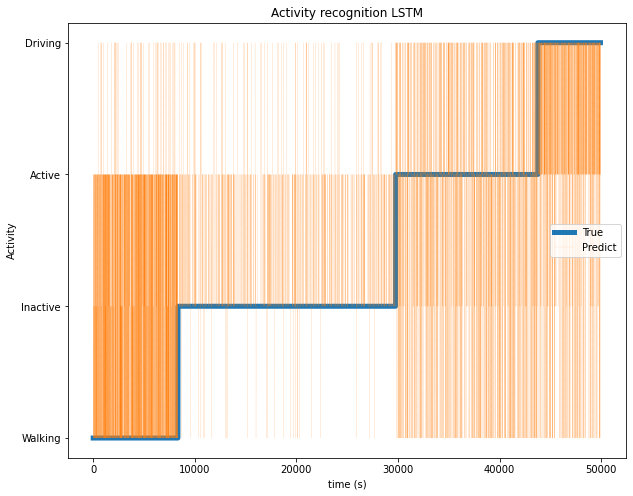

In [ ]:
def visualize_activity_recognition(t, label_true, label_pred_mode, label_classes,name):
    plt.figure(figsize=(10, 8))
    plt.title("Activity recognition {}".format(name))
    plt.plot(t, label_true, linewidth=5.0)
    plt.plot(t.reshape(-1), label_pred_mode.reshape(-1), '--', linewidth=0.10)
    plt.yticks(np.arange(len(label_classes)), label_classes)
    plt.xlabel("time (s)")
    plt.ylabel("Activity")
    plt.legend(["True", "Predict"])
    plt.show()

num = len(Y_cat)
t = np.arange(0,num*1,1)
visualize_activity_recognition(t, Y_cat, Y_pred_cat, LABELS,"LSTM")

In [ ]:
model.save('drive/MyDrive/Thesis/Test Data/HAR Spain/Driving_model')
pickle.dump(model_history.history, open("drive/MyDrive/Thesis/Test Data/HAR Spain/Driving_model_history", "wb"))
print("Saved model to disk")

Saved model to disk


In [3]:
# Try on our own Data
# load data from saved matlab file
#D = loadmat("drive/MyDrive/Thesis/Codes/Bob event classification/results.mat")
model = load_model('drive/MyDrive/Thesis/Test Data/HAR Spain/Driving_model')
D = loadmat("drive/MyDrive/Thesis/Codes/Driving/results.mat")
print(D.keys())

aC = D['aC']/2
gC = D['gyroC']
des = D['des'].reshape((-1,1))

aC[:, [0, 1]] = aC[:, [1, 0]]
gC[:, [0, 1]] = gC[:, [1, 0]]

print(aC.shape, gC.shape, des.shape)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

dict_keys(['__header__', '__version__', '__globals__', 'aC', 'des', 'gyroC'])
(0, 3) (0, 3) (0, 1)


In [ ]:
def extract_features(x, y, window, step):
  num = x.shape[0]
  X = []
  Y = []
  for i in range(0, num - window, step):
    mean = np.mean(x[i:i + window], axis=0)
    var = np.var(x[i: i + window], axis=0)
    part = np.append(mean.reshape(1,-1),var.reshape(1,-1), axis=1)
    part = np.mean(part,axis=0)
    label = stats.mode(y[i: i + window])[0][0]
    X.append(part)
    Y.append(label)
  return np.array(X), np.array(Y)

aC_ex,y = extract_features(aC, des, 1500, 10)
gC_ex,y = extract_features(gC, des, 1500, 10)

data_app = np.append(aC_ex,gC_ex,axis=1)

print(aC_ex.shape, gC_ex.shape, y.shape, data_app.shape)

N_TIME_STEPS = 20
step = 1 # faster with bigger step but accuracy degrades fast
X = []
Y = []
for i in range(0, len(aC_ex) - N_TIME_STEPS, step):
    part = data_app[i: i + N_TIME_STEPS]
    label = stats.mode(y[i: i + N_TIME_STEPS])[0][0]
    X.append(part)
    Y.append(label)
Y_binary = to_categorical(Y)
X = np.array(X)
Y = np.array(Y)
print(X.shape, Y.shape)


n_features, n_steps, n_length = X.shape[2], 2, 10
X = X.reshape((X.shape[0], n_steps, 1, n_length, n_features))
Y_cat = np.argmax(Y_binary, axis=1)
Y_pred = model.predict(np.array(X))
np.shape(Y_pred)

Y_pred[:,0] = Y_pred[:,0]*8

(938, 6) (938, 6) (938, 1) (938, 12)
(918, 20, 12) (918, 1)


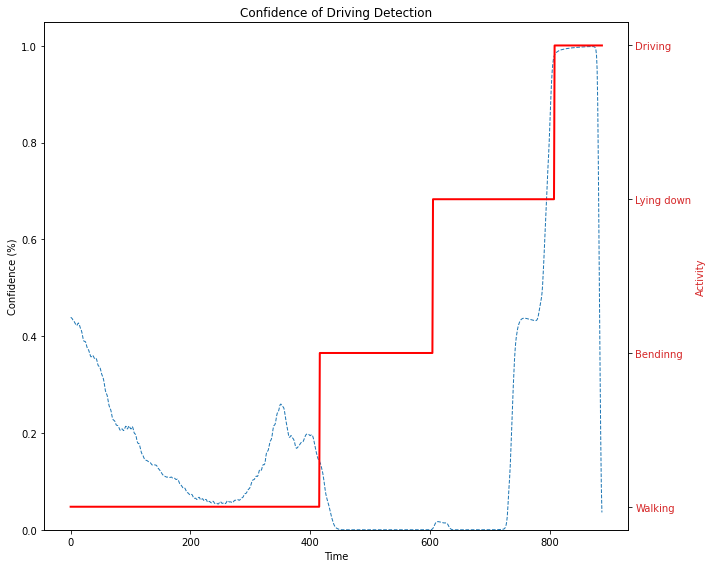

In [ ]:
label_classes = ['Walking','Bendinng','Lying down','Driving']

fig, ax1 = plt.subplots(figsize=(10,8))
plt.plot(np.array(Y_pred[:-30,3]),'--', linewidth=1.0, label="True") # try also Y_pred[:-30,0])
plt.title("Confidence of Driving Detection")
plt.ylabel('Confidence (%)')
plt.xlabel('Time')
plt.ylim(0)
ax1.tick_params(axis='y')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Activity', color='tab:red')
ax2.plot(np.array(Y[:-30]),'r', linewidth=2.0, label="Predict")
ax2.set_yticks(np.arange(len(label_classes)))
ax2.set_yticklabels(label_classes, fontdict=None, minor=False)
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()
plt.show()

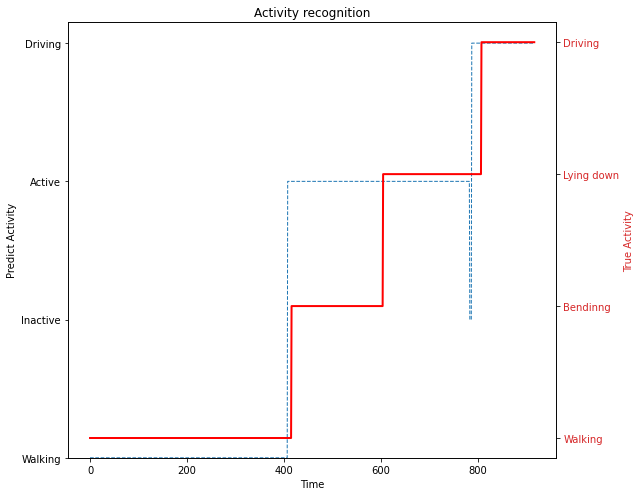

In [ ]:
def visualize_activity_recognition(t, label_true, label_pred_mode, label_classes,name):
    plt.figure(figsize=(10, 8))
    plt.title("Activity recognition {}".format(name))
    plt.plot(t, label_true, linewidth=5.0)
    plt.plot(t.reshape(-1), label_pred_mode.reshape(-1), '--', linewidth=1.0)
    plt.yticks(np.arange(len(label_classes)), label_classes)
    plt.xlabel("time (s)")
    plt.ylabel("Activity")
    plt.legend(["True", "Predict"])
    plt.show()

num = len(Y_cat)
t = np.arange(0,num*1,1)
Y_pred_roll = np.roll(np.argmax(Y_pred,axis=1),45)
Y_pred_roll[0:45] = 0
#visualize_activity_recognition(t, Y_cat, Y_pred_roll, LABELS,"LSTM")



label_classes = ['Walking','Bendinng','Lying down','Driving']

fig, ax1 = plt.subplots(figsize=(9,7))
plt.plot(t,np.array(Y_pred_roll),'--', linewidth=1.0, label="Predict") # try also Y_pred[:-30,0])
plt.yticks(np.arange(len(LABELS)), LABELS)
plt.title("Activity recognition")
plt.ylabel('Predict Activity')
plt.xlabel('Time')
plt.ylim(0)
ax1.tick_params(axis='y')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('True Activity', color='tab:red')
ax2.plot(t,np.array(Y_cat),'r', linewidth=2.0, label="True")
ax2.set_yticks(np.arange(len(label_classes)))
ax2.set_yticklabels(label_classes, fontdict=None, minor=False)
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()
plt.show()

In [45]:
# Try on our own Data
# load data from saved matlab file
#D = loadmat("drive/MyDrive/Thesis/Codes/Bob event classification/results.mat")
model = load_model('drive/MyDrive/Thesis/Test Data/HAR Spain/Driving_model')
D = loadmat("drive/MyDrive/Thesis/Codes/Patients/UMN_008/14/matlab.mat")
print(D.keys())

aC = D['aChest'][434000:610000]*100
gC = D['tiltCRate'][434000:610000]*180/3.14
des = D['events'][434000:610000].reshape((-1,1))
gC2 = np.append(gC,gC, axis=1)
gC = np.append(gC2,gC, axis=1)

#aC[:,1] = aC[:,1] - 9.5;
aC[:, [0, 1]] = aC[:, [1, 0]]
gC[:, [0, 1]] = gC[:, [1, 0]]

print(aC.shape, gC.shape, des.shape)

dict_keys(['__header__', '__version__', '__globals__', 'aChest', 'aLeft', 'aRight', 'events', 'tiltCRate', 'tiltLRate', 'tiltRRate', 'None', '__function_workspace__'])
(176000, 3) (176000, 3) (704000, 1)


In [46]:
def extract_features(x, y, window, step):
  num = x.shape[0]
  X = []
  Y = []
  for i in range(0, num - window, step):
    mean = np.mean(x[i:i + window], axis=0)
    var = np.var(x[i: i + window], axis=0)
    part = np.append(mean.reshape(1,-1),var.reshape(1,-1), axis=1)
    part = np.mean(part,axis=0)
    label = stats.mode(y[i: i + window])[0][0]
    X.append(part)
    Y.append(label)
  return np.array(X), np.array(Y)

aC_ex,y = extract_features(aC, des, 1500, 10)
gC_ex,y = extract_features(gC, des, 1500, 10)

data_app = np.append(aC_ex,gC_ex,axis=1)

print(aC_ex.shape, gC_ex.shape, y.shape, data_app.shape)

N_TIME_STEPS = 20
step = 1 # faster with bigger step but accuracy degrades fast
X = []
Y = []
for i in range(0, len(aC_ex) - N_TIME_STEPS, step):
    part = data_app[i: i + N_TIME_STEPS]
    label = stats.mode(y[i: i + N_TIME_STEPS])[0][0]
    X.append(part)
    Y.append(label)
Y_binary = to_categorical(Y)
X = np.array(X)
Y = np.array(Y)
print(X.shape, Y.shape)


n_features, n_steps, n_length = X.shape[2], 2, 10
X = X.reshape((X.shape[0], n_steps, 1, n_length, n_features))
Y_cat = np.argmax(Y_binary, axis=1)
Y_pred = model.predict(np.array(X))
np.shape(Y_pred)

Y_pred[:,0] = Y_pred[:,0]*8

(17450, 6) (17450, 6) (17450, 1) (17450, 12)
(17430, 20, 12) (17430, 1)


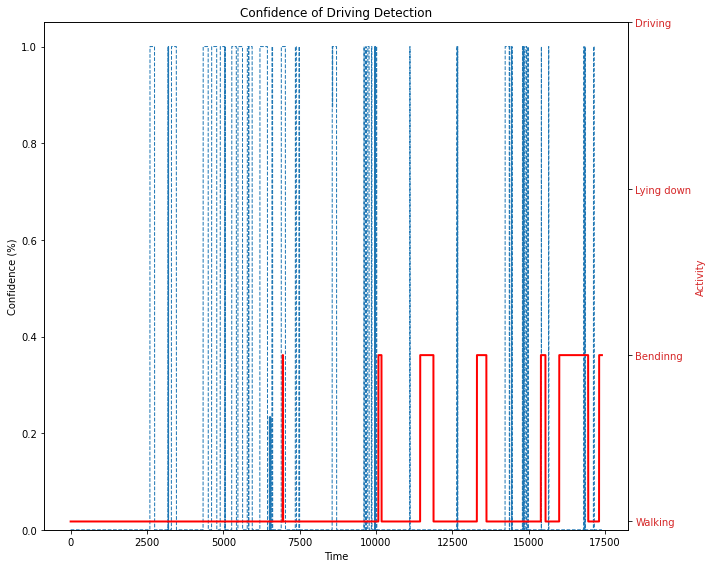

In [47]:
label_classes = ['Walking','Bendinng','Lying down','Driving']

fig, ax1 = plt.subplots(figsize=(10,8))
plt.plot(np.array(Y_pred[:-30,3]),'--', linewidth=1.0, label="True") # try also Y_pred[:-30,0])
plt.title("Confidence of Driving Detection")
plt.ylabel('Confidence (%)')
plt.xlabel('Time')
plt.ylim(0)
ax1.tick_params(axis='y')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Activity', color='tab:red')
ax2.plot(np.array(Y[:-30]),'r', linewidth=2.0, label="Predict")
ax2.set_yticks(np.arange(len(label_classes)))
ax2.set_yticklabels(label_classes, fontdict=None, minor=False)
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()
plt.show()